# RNN approach to the Upgrade classifier 

This notebook is dedicated to storing my study on a recurrent neural network to classify the track seeds. In these exercises I'll build a model that uses only hits information in order to make a prediction. 

Study roadmap:

1. Import an FT hits data and converts it into time series. This point will be a little bit challenging since hits need to be coded. 
2. Build a model that use LSTM units to classify the tracks
3. Compare the result to the track information NN. 


Open questions:
1. What is the meaning of repetited planeID?

In [1]:
import sys
!{sys.executable} -m pip install --upgrade tmpfile


ERROR: Could not find a version that satisfies the requirement tmpfile (from versions: none)
ERROR: No matching distribution found for tmpfile


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import random
import itertools

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset,ConcatDataset
from torch.autograd import Variable


from timeit import default_timer as timer
from tqdm.notebook import tqdm
from multiprocessing import Pool
import tempfile


In [2]:
hits_df = pd.read_pickle("/data/work/wessex/Wessex/test/FT_hits.pickle")

In [4]:
hits_df.drop_duplicates(subset="track_id", keep="last", inplace=True)

In [14]:
hits_df.features.iloc[2]

array([[-0.00000000e+00,  1.00000000e+00,  3.46020740e+01,
         1.01266003e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.74892300e-02,  1.00000000e+00,  3.46020740e+01,
         1.09852920e+03],
       [-0.00000000e+00,  1.00000000e+00,  3.46020740e+01,
         1.08023510e+03],
       [-0.00000000e+00,  1.00000000e+00,  3.46020740e+01,
         1.23514000e+03],
       [ 8.74892300e-02,  1.00000000e+00,  3.46020740e+01,
         1.21467610e+03],
       [-8.74892300e-02,  1.00000000e+00,  3.46020740e+01,
         1.32554310e+03],
       [-0.00000000e+00,  1.00000000e+00,  3.46020740e+01,
         1.30491500e+03],
       [-0.00000000e+00,  1.00000000e+00,  3.46020740e+01,
         1.46428990e+03],
       [ 8.74892300e-02,  1.00000000e+00,  3.46020740e+01,
         1.44068620e+03],
       [-8.74892300e-02,  1.00000000e+00,  3.46020740e+01,
         1.55883080e+03],
       [-0.00000000e+00,  1.00000000e+00,  2.50000000e+01,
      

In [52]:
# the above code can be used to normalize input vectors. Although, I am not sure if this is a good idea. 
# the outcome dependes on a number of zeros. 

In [16]:
a = hits_df.head(1000).features.to_numpy()

In [34]:
nda = np.dstack(a)

In [51]:
nda -  nda.mean(axis=-1).mean(axis=0).reshape((4,1))

array([[[ 1.45815383e-05,  1.45815383e-05,  1.45815383e-05, ...,
          1.45815383e-05,  1.45815383e-05,  1.45815383e-05],
        [-4.69833333e-01, -4.69833333e-01,  5.30166667e-01, ...,
          5.30166667e-01,  5.30166667e-01, -4.69833333e-01],
        [-3.62913645e+01, -1.12913645e+01, -1.68929054e+00, ...,
         -1.68929054e+00, -1.68929054e+00, -1.68929054e+00],
        [ 2.36345921e+01,  1.44834969e+03,  1.03629462e+03, ...,
          1.50844602e+02, -6.24575368e+02,  8.83169622e+02]],

       [[ 1.45815383e-05,  8.75038115e-02,  1.45815383e-05, ...,
          8.75038115e-02,  8.75038115e-02,  8.75038115e-02],
        [-4.69833333e-01, -4.69833333e-01, -4.69833333e-01, ...,
          5.30166667e-01,  5.30166667e-01, -4.69833333e-01],
        [-3.62913645e+01, -1.68929054e+00, -3.62913645e+01, ...,
         -1.68929054e+00, -1.68929054e+00, -1.12913645e+01],
        [ 2.36345921e+01,  1.57706979e+03,  2.36345921e+01, ...,
          1.42285072e+02, -7.48354058e+02,  9.46068

In [5]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")

In [6]:
track_data = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "particle_hasUT",
                      "particle_pid", # this is MC info
                      "particle_hasScifi",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)
track_data["track_id"] = track_data.apply(lambda row: (row["eventID"], row["particle_key"]), axis=1 )
track_data.head()

,eventID,track_phi,track_tx,track_ty,track_nLHCbIDs,particle_key,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi,particle_isDown_noVelo,track_id
0,31123,2.849378,-0.343474,0.103326,12.0,997,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534,False,"(31123, 997)"
1,31123,-3.082239,-0.358948,-0.021330,12.0,1061,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232,False,"(31123, 1061)"
2,31123,-0.011027,0.096606,-0.001065,11.0,1066,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707,False,"(31123, 1066)"
3,31123,3.105371,-0.442834,0.016047,9.0,1105,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953,False,"(31123, 1105)"
4,31123,-3.125277,-0.170356,-0.002780,11.0,1184,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312,False,"(31123, 1184)"


In [8]:
track_data.drop(["eventID","particle_key"], axis=1, inplace=True)

In [9]:
track_data.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi,particle_isDown_noVelo,track_id
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534,False,"(31123, 997)"
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232,False,"(31123, 1061)"
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707,False,"(31123, 1066)"
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953,False,"(31123, 1105)"
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312,False,"(31123, 1184)"


In [10]:
cmbined_data = track_data.merge(hits_df,
                               on="track_id",
                               how="left")

In [23]:
cmbined_data = cmbined_data[cmbined_data['target'].notna()]

In [17]:
cmbined_data.particle_isDown_noVelo = cmbined_data.particle_isDown_noVelo.astype(int)

In [25]:
cmbined_data.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi,track_id,features,target
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534,"(31123, 997)","[[-0.0, 1.0, 34.602074, 378.965], [0.08748923,...",0.0
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232,"(31123, 1061)","[[0.0, 0.0, 34.602074, -1198.815], [0.08748923...",0.0
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707,"(31123, 1066)","[[0.0, 0.0, 34.602074, 267.115], [0.08748923, ...",0.0
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953,"(31123, 1105)","[[-0.0, 1.0, 34.602074, -405.29], [0.08748923,...",0.0
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312,"(31123, 1184)","[[0.0, 0.0, 34.602074, -495.64], [0.08748923, ...",0.0


In [30]:
class HitsWithTracksDataset(Dataset):
    def __init__(self, hits_df, track_df):
        self.hit_features = hits_df.features
        self.track_features = track_df
        self.target  = hits_df.target
        

    def __getitem__(self,index):        
        return (torch.Tensor(self.track_features.iloc[index]),
                torch.tensor(self.hit_features.iloc[index]),
                torch.tensor(self.target.iloc[index]))
        
    def __len__(self):
        return len(self.target)

In [31]:
X_train, X_valid = train_test_split(cmbined_data, test_size=0.2, random_state=12)

In [39]:
X_train_hits = X_train[["features","target"]]
X_train_tracks = X_train.drop(["features","target","track_id"],axis=1)

X_valid_hits = X_valid[["features","target"]]
X_valid_tracks = X_valid.drop(["features","target","track_id"],axis=1)

In [40]:
X_train_tracks.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
2515564,0.228825,0.244668,0.056984,12.0,3332.727302,9.506754,33.876434,464.236938,1.358108,812.006409,2.090003,7514.430354,1.497953
5327399,0.097754,0.641672,0.062927,12.0,2178.160352,8.360332,1473.569092,601.963379,1.194333,1180.307957,1.222718,7667.057178,0.387818
3157043,0.056733,0.810708,0.046043,10.0,1776.674875,4.745351,1547.039795,641.032410,0.949070,1119.954563,1.035987,7684.676615,0.392825
3655435,-2.881100,-0.080149,-0.021364,12.0,15479.515780,2.808749,-239.034119,-169.015625,0.401250,1279.587920,3.184414,7505.711398,-2.526133
2360240,-0.082528,0.079708,-0.006593,12.0,11982.581328,1.320090,121.448929,-67.612083,0.188584,955.317732,3.220720,7501.287972,-0.507982


In [41]:
X_valid_tracks = (X_valid_tracks - X_train_tracks.mean()) / X_train_tracks.std()
X_train_tracks = (X_train_tracks - X_train_tracks.mean()) / X_train_tracks.std()


In [42]:
X_train_tracks.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
2515564,0.117528,0.805444,0.946779,0.716983,-0.006258,1.841356,0.027917,1.000326,1.559017,-0.011251,-0.468302,-0.567504,0.785628
5327399,0.052894,2.166221,1.045463,0.716983,-0.006916,1.477097,1.951745,1.297183,1.231738,-0.004200,-1.468615,1.785549,0.204551
3157043,0.032666,2.745611,0.765071,-2.125336,-0.007145,0.328488,2.049922,1.381393,0.741618,-0.005356,-1.683987,2.057189,0.207171
3655435,-1.416032,-0.307905,-0.354394,0.716983,0.000668,-0.286839,-0.336767,-0.364595,-0.353117,-0.002299,0.793974,-0.701925,-1.320695
2360240,-0.036006,0.240023,-0.109092,0.716983,-0.001326,-0.759839,0.144939,-0.146029,-0.778097,-0.008507,0.835848,-0.770121,-0.264337


In [44]:
datasets={
    "train":HitsWithTracksDataset(X_train_hits, X_train_tracks ),
    "valid":HitsWithTracksDataset(X_valid_hits,X_valid_tracks)
}


In [56]:
def create_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target.astype(int)])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    return torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))



In [57]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=256,
                    sampler = create_sampler(X_train_hits.target),
                    num_workers=5),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=5)
}

In [59]:
    for batch in dataloaders["train"]:
        print("track features", batch[0], batch[0].shape)
        print("hit fetarures", batch[1], len(batch[1]))
        print("target", batch[2], len(batch[2]))

        break

track features tensor([[ 1.3618, -0.3988,  0.7276,  ...,  0.4159, -0.5578,  1.2384],
        [-1.0994, -0.6479, -3.7730,  ..., -0.6261,  2.5489, -0.8822],
        [-1.4635, -1.3816, -1.0830,  ..., -0.9757, -0.1202, -1.4479],
        ...,
        [ 1.5459, -2.4206,  0.1883,  ..., -1.5427,  1.9068,  1.6442],
        [ 0.0319,  2.2193,  0.6035,  ..., -1.4885,  1.6501,  0.1153],
        [ 0.0473,  0.7414,  0.3258,  ..., -0.3538, -0.3858,  0.1148]]) torch.Size([256, 13])
hit fetarures tensor([[[-0.0000e+00,  1.0000e+00,  3.4602e+01, -3.7384e+02],
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01, -4.1187e+02],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -3.5798e+02],
         ...,
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01, -5.6964e+02],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -5.0557e+02],
         [-0.0000e+00,  1.0000e+00,  3.4602e+01, -5.4986e+02]],

        [[ 0.0000e+00,  0.0000e+00,  3.4602e+01, -2.7037e+02],
         [ 8.7489e-02,  0.0000e+00,  3.4602e+01, -1.1720e+

# Build a model 

In [106]:
class UpgradeTrackerNN(nn.Module):
    def __init__(self, config):
        super(UpgradeTrackerNN, self).__init__()
        # construct LSTM 
        self.num_layers_lstm = config["num_layers_lstm"]
        self.hidden_size_lstm = config["hidden_size_lstm"]
        self.batch_size = config["batch_size"]

        self.rnn = nn.LSTM(
            input_size= config["lstm_input_size"],
            hidden_size= self.hidden_size_lstm,
            num_layers=self.num_layers_lstm,
            batch_first=True,
        )
        #construct linear model
        self.input_layer = nn.Linear(config["track_input_size"]+self.hidden_size_lstm,
                                   config["liner_hidden_dict"][0])
        
        self.linear_module = nn.ModuleList()
        for layer_it in range(config["linear_n_hidden"]-1):
            self.linear_module.append(nn.Linear(config["liner_hidden_dict"][layer_it],
                                       config["liner_hidden_dict"][layer_it+1])
                              )
            
        self.output_layer = nn.Linear(config["liner_hidden_dict"][config["linear_n_hidden"]-1], 2)
        
        #init model
        self.linear_module.apply(self._init_weights)
        self._init_weights(self.input_layer)
        self._init_weights(self.output_layer)
        self.hidden = self.init_hidden()

    def forward(self, hits, tracks):
        # Avoid breaking if the last batch has a different size
        batch_size = hits.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        # make sure hits are type of float    
        hits = hits.float()
        output, self.hidden = self.rnn(hits, self.init_hidden())
        return self._forward_linear(output[:,-1,:],tracks)
        
        
    def init_hidden(self):
        hidden = Variable(torch.zeros(self.num_layers_lstm, self.batch_size, self.hidden_size_lstm)).to(device)
        cell =  Variable(torch.zeros(self.num_layers_lstm, self.batch_size, self.hidden_size_lstm)).to(device)
        return (hidden, cell)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)
    
    def _forward_linear(self, hits_lstm, tracks):
        x = torch.cat([hits_lstm, tracks], dim=1)
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.linear_module:
            x = layer(x)
            x = F.relu(x)
        return self.output_layer(x)


In [107]:
config ={
    "lstm_input_size":4,
    "num_layers_lstm":3,
    "hidden_size_lstm":32,
    "batch_size":256,
    "track_input_size": X_train_tracks.shape[1],
    "linear_n_hidden":4,
    "liner_hidden_dict":{0:40,
                        1:30,
                        2:20,
                        3:10}
}

model = UpgradeTrackerNN(config)
model.to(device)
model


UpgradeTrackerNN(
  (rnn): LSTM(4, 32, num_layers=3, batch_first=True)
  (input_layer): Linear(in_features=45, out_features=40, bias=True)
  (linear_module): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [109]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([128, 4])
rnn.weight_hh_l0 	 torch.Size([128, 32])
rnn.bias_ih_l0 	 torch.Size([128])
rnn.bias_hh_l0 	 torch.Size([128])
rnn.weight_ih_l1 	 torch.Size([128, 32])
rnn.weight_hh_l1 	 torch.Size([128, 32])
rnn.bias_ih_l1 	 torch.Size([128])
rnn.bias_hh_l1 	 torch.Size([128])
rnn.weight_ih_l2 	 torch.Size([128, 32])
rnn.weight_hh_l2 	 torch.Size([128, 32])
rnn.bias_ih_l2 	 torch.Size([128])
rnn.bias_hh_l2 	 torch.Size([128])
input_layer.weight 	 torch.Size([40, 45])
input_layer.bias 	 torch.Size([40])
linear_module.0.weight 	 torch.Size([30, 40])
linear_module.0.bias 	 torch.Size([30])
linear_module.1.weight 	 torch.Size([20, 30])
linear_module.1.bias 	 torch.Size([20])
linear_module.2.weight 	 torch.Size([10, 20])
linear_module.2.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [110]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

25682

In [119]:
# check if model works
device = "cpu"
model.to(device)
for batch in dataloaders["train"]:
    track, hits, labels  = batch
    preds =  model(hits, track)
    print(preds[:2:])
    break


tensor([[ 0.1773, -0.3740],
        [ 0.3062, -0.2150]], grad_fn=<SliceBackward>)


In [124]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                track, hits, labels  = batch
                track = track.to(device)
                hits = hits.to(device)
                labels = labels.to(device)

                outputs = model(hits, track)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * track.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [126]:
lr = 1e-4
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion =torch.nn.CrossEntropyLoss().to(device)

In [127]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=3)


Epoch 1/3
----------


train loss: 0.6461, train acc: 0.6216, elapsed:324.2719


valid loss: 0.6162, valid acc: 0.6306, elapsed:86.9701

Epoch 2/3
----------


train loss: 0.6146, train acc: 0.6551, elapsed:326.6437


valid loss: 0.6100, valid acc: 0.6392, elapsed:87.3697

Epoch 3/3
----------


train loss: 0.5952, train acc: 0.6700, elapsed:327.4397


valid loss: 0.5860, valid acc: 0.6587, elapsed:88.6264
training took:  1241.3232442080043


In [133]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.5845, train acc: 0.6761, elapsed:325.3326


valid loss: 0.5790, valid acc: 0.6726, elapsed:88.1695

Epoch 2/10
----------


train loss: 0.5789, train acc: 0.6790, elapsed:326.1530


valid loss: 0.5864, valid acc: 0.6685, elapsed:87.6091

Epoch 3/10
----------


train loss: 0.5748, train acc: 0.6816, elapsed:326.1169


valid loss: 0.5541, valid acc: 0.7105, elapsed:87.5004

Epoch 4/10
----------


train loss: 0.5722, train acc: 0.6837, elapsed:328.3054


valid loss: 0.5911, valid acc: 0.6660, elapsed:88.0311

Epoch 5/10
----------


train loss: 0.5704, train acc: 0.6848, elapsed:327.1604


valid loss: 0.5777, valid acc: 0.6854, elapsed:87.5062

Epoch 6/10
----------


train loss: 0.5689, train acc: 0.6857, elapsed:329.6939


valid loss: 0.5831, valid acc: 0.6774, elapsed:88.2762

Epoch 7/10
----------


train loss: 0.5681, train acc: 0.6861, elapsed:330.9116


valid loss: 0.5730, valid acc: 0.6918, elapsed:88.5741

Epoch 8/10
----------


train loss: 0.5674, train acc: 0.6866, elapsed:327.6199


valid loss: 0.5719, valid acc: 0.6897, elapsed:88.7486

Epoch 9/10
----------


train loss: 0.5665, train acc: 0.6872, elapsed:327.4095


valid loss: 0.5512, valid acc: 0.7141, elapsed:88.3470

Epoch 10/10
----------


train loss: 0.5658, train acc: 0.6879, elapsed:328.4327


valid loss: 0.5836, valid acc: 0.6773, elapsed:88.7301
training took:  4158.63338956004


In [134]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


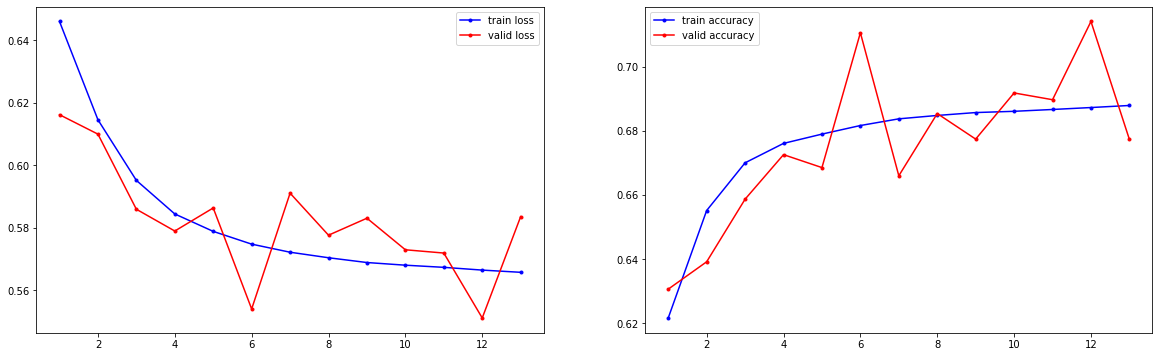

In [135]:
plot_training_classification(run_hist)

In [137]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, "RNN_with_tracks_1.pt")


In [138]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=64,
                    sampler = create_sampler(X_train_hits.target),
                    num_workers=5),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      sampler = create_sampler(X_valid_hits.target),
                      num_workers=5)
}

In [139]:
model.to(device)

UpgradeTrackerNN(
  (rnn): LSTM(4, 32, num_layers=3, batch_first=True)
  (input_layer): Linear(in_features=45, out_features=40, bias=True)
  (linear_module): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [25]:
def make_prediction(dataloader, model):
    model.eval() 
    outputs = []
    batch_iterator = tqdm(iter(dataloader), leave=False, total=len(dataloader))
    for i, batch in enumerate(dataloader):
            inputs, _ = batch
            inputs = inputs.to(device)
            logits = model(inputs.float())
            outputs.append(logits.detach().cpu())
    logits = torch.cat(outputs)
    probas = torch.softmax(logits, dim=1)
    return probas

In [140]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=15)


Epoch 1/15
----------


train loss: 0.5673, train acc: 0.6867, elapsed:682.3824


valid loss: 0.5675, valid acc: 0.6868, elapsed:89.0830

Epoch 2/15
----------


train loss: 0.5661, train acc: 0.6876, elapsed:680.0845


valid loss: 0.5652, valid acc: 0.6884, elapsed:90.3112

Epoch 3/15
----------


train loss: 0.5652, train acc: 0.6886, elapsed:679.6763


valid loss: 0.5649, valid acc: 0.6884, elapsed:88.9032

Epoch 4/15
----------


train loss: 0.5642, train acc: 0.6891, elapsed:678.9876


valid loss: 0.5645, valid acc: 0.6894, elapsed:89.1173

Epoch 5/15
----------


train loss: 0.5636, train acc: 0.6894, elapsed:678.7172


valid loss: 0.5651, valid acc: 0.6880, elapsed:88.5846

Epoch 6/15
----------


train loss: 0.5629, train acc: 0.6900, elapsed:678.4389


valid loss: 0.5646, valid acc: 0.6896, elapsed:88.7649

Epoch 7/15
----------


train loss: 0.5623, train acc: 0.6904, elapsed:681.1814


valid loss: 0.5628, valid acc: 0.6902, elapsed:88.7561

Epoch 8/15
----------


train loss: 0.5620, train acc: 0.6903, elapsed:681.2722


valid loss: 0.5634, valid acc: 0.6905, elapsed:88.7091

Epoch 9/15
----------


train loss: 0.5614, train acc: 0.6912, elapsed:684.5192


valid loss: 0.5624, valid acc: 0.6897, elapsed:88.5332

Epoch 10/15
----------


train loss: 0.5611, train acc: 0.6911, elapsed:682.6728


valid loss: 0.5613, valid acc: 0.6914, elapsed:89.4667

Epoch 11/15
----------


train loss: 0.5609, train acc: 0.6913, elapsed:682.5754


valid loss: 0.5622, valid acc: 0.6902, elapsed:89.4579

Epoch 12/15
----------


train loss: 0.5603, train acc: 0.6917, elapsed:680.3462


valid loss: 0.5606, valid acc: 0.6923, elapsed:89.1167

Epoch 13/15
----------


train loss: 0.5601, train acc: 0.6919, elapsed:681.1453


valid loss: 0.5635, valid acc: 0.6891, elapsed:88.9368

Epoch 14/15
----------


train loss: 0.5596, train acc: 0.6923, elapsed:682.6837


valid loss: 0.5608, valid acc: 0.6918, elapsed:88.9297

Epoch 15/15
----------


train loss: 0.5595, train acc: 0.6921, elapsed:679.3724


valid loss: 0.5599, valid acc: 0.6920, elapsed:89.4649
training took:  11550.1982036829


In [141]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".RNN_with_tracks_2.pt")


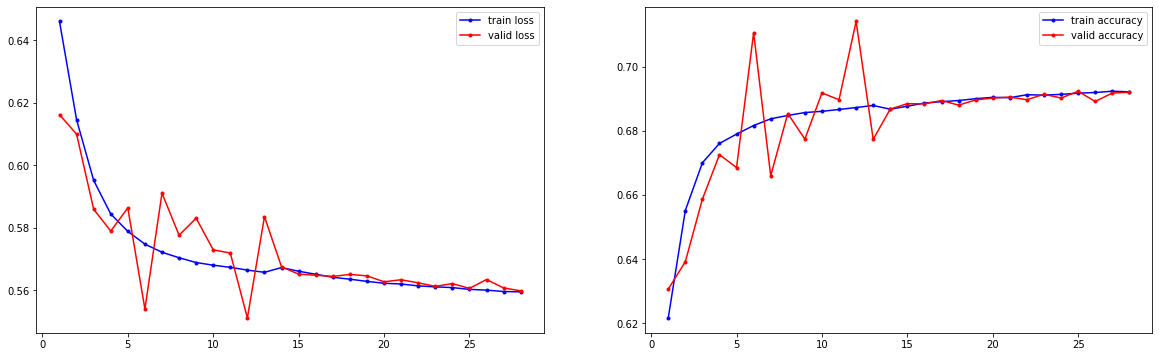

In [142]:
plot_training_classification(run_hist)

In [143]:
learning_rate = 1e-5
optimizer_2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer_2,run_hist= run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.5568, train acc: 0.6947, elapsed:678.0735


valid loss: 0.5579, valid acc: 0.6934, elapsed:89.4309

Epoch 2/10
----------


train loss: 0.5565, train acc: 0.6946, elapsed:678.0193


valid loss: 0.5586, valid acc: 0.6930, elapsed:89.2602

Epoch 3/10
----------


train loss: 0.5567, train acc: 0.6946, elapsed:679.1054


valid loss: 0.5577, valid acc: 0.6938, elapsed:89.1003

Epoch 4/10
----------


train loss: 0.5561, train acc: 0.6951, elapsed:678.8573


valid loss: 0.5576, valid acc: 0.6943, elapsed:87.9484

Epoch 5/10
----------


train loss: 0.5561, train acc: 0.6949, elapsed:676.2247


valid loss: 0.5586, valid acc: 0.6932, elapsed:88.5186

Epoch 6/10
----------


train loss: 0.5558, train acc: 0.6952, elapsed:682.9940


valid loss: 0.5586, valid acc: 0.6931, elapsed:88.5376

Epoch 7/10
----------


train loss: 0.5565, train acc: 0.6946, elapsed:680.3330


valid loss: 0.5579, valid acc: 0.6937, elapsed:88.3564

Epoch 8/10
----------


train loss: 0.5565, train acc: 0.6946, elapsed:682.2011


valid loss: 0.5580, valid acc: 0.6931, elapsed:89.0276

Epoch 9/10
----------


train loss: 0.5562, train acc: 0.6948, elapsed:678.2782


valid loss: 0.5571, valid acc: 0.6946, elapsed:88.5805

Epoch 10/10
----------


In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".RNN_with_tracks_3.pt")


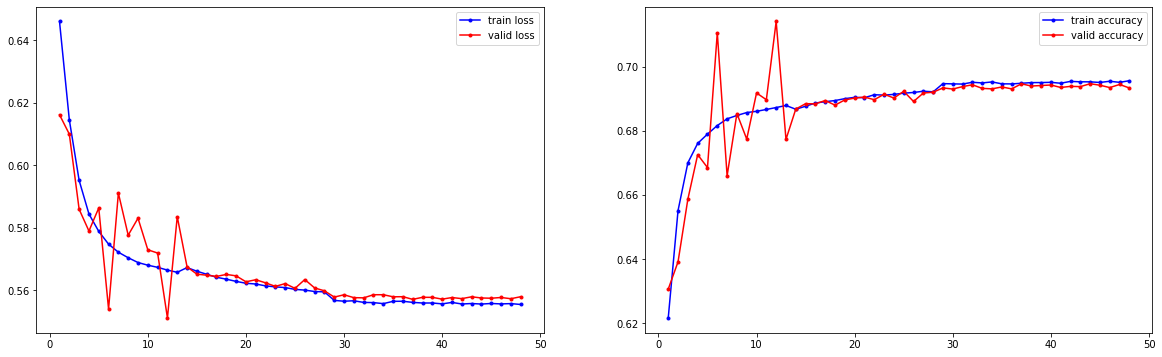

In [149]:
plot_training_classification(run_hist)

In [150]:
learning_rate = 1e-6
optimizer_3 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer_3,run_hist= run_hist, num_epochs=3)


Epoch 1/3
----------


train loss: 0.5555, train acc: 0.6955, elapsed:676.1559


valid loss: 0.5570, valid acc: 0.6944, elapsed:89.9564

Epoch 2/3
----------
